In [105]:
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
import numpy as np

import achiralqw as aqw

from achiralqw.graph import QWGraph, QWGraphBuilder as qwgb, QWGraphBuilder
from achiralqw.plotter import plot_qwgraph, plot_evo_mat_heatmap, plot_evo_vs_phase, plot_performance, set_progression_plot
from achiralqw.simulator import EigenSESolver, QutipSESolver
from achiralqw.analyze import TransportParameters, performance, performance_best, optimum_phase

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
#QWgraph simulation with pure state is equivalent to solving Schrodinger's equation
# archiralqw has a standard interface for a Solver, which consists in anything capable of taking a graph as an input and computing the value and derivative with respect of time of both the probability amplitude and actual probability in any target vertex
# If given no further specification the solver defaults at computing the required quantity in the target vertex of the graph.

# here we evolve the graph using its third site as a start state
gr = qwgb.Line(5)

esolver = EigenSESolver()
A = esolver.evolve_state(gr, psi = gr.basis(3), t = 5)
A_prim = esolver.evolve_state_deriv(gr, psi = gr.basis(3), t = 5)
print(A)


#or compue the derivative of the probability in the same conditions
p = esolver.evolve_state_p(gr, psi = gr.basis(3), t = 5)
p_prime = esolver.evolve_state_p_deriv(gr, psi = gr.basis(3), t = 5)
print(p_prime)


[[ 2.08166817e-16+6.79281185e-01j]
 [-5.02687081e-01-5.27355937e-16j]
 [-8.88178420e-16+3.99638096e-01j]
 [-2.19024896e-01-7.77156117e-16j]
 [-6.80011603e-16-2.79643089e-01j]]
[[-0.68293175]
 [ 1.08471757]
 [-0.5768472 ]
 [ 0.05256379]
 [ 0.1224976 ]]


In [38]:
# In the package there are two implementation of the solver
# EigenSESolver, which uses eigenstate decomposition to perform the evolution
# QutipSESolver, which employs the PDE solver provided by Qutip

qsolver = QutipSESolver()
esolver = EigenSESolver()

#of course they agree on the results
gr = qwgb.Ring(4)

print(  esolver.evolve_default(gr, 5), "\t", qsolver.evolve_default(gr, 5))
print(  esolver.evolve_default_deriv(gr, 6), "\t", qsolver.evolve_default_deriv(gr, 6))
print(  esolver.evolve_default_p(gr, 7), "\t", qsolver.evolve_default_p(gr, 7))
print(  esolver.evolve_default_p_deriv(gr, 8), "\t", qsolver.evolve_default_p_deriv(gr, 8))



[-0.91953576-1.11022302e-16j] 	 [-0.91953736+0.j]
[0.53657292+2.77555756e-16j] 	 [0.5365767+0.j]
[0.18630566] 	 [0.18630441]
[-0.56361666] 	 [-0.56360338]


In [46]:
#solvers also support vecorized t input

t_vec = np.linspace(0, 10, 4)
print(  esolver.evolve_default(gr, t_vec), "\n\n", qsolver.evolve_default(gr, t_vec))


[-2.77555756e-17+0.00000000e+00j -3.63161485e-02-6.59901663e-17j
 -1.39989143e-01-1.36505956e-16j -2.95958969e-01-2.29293369e-16j] 

 [ 0.        +0.j -0.03631669+0.j -0.13999038+0.j -0.29596083+0.j]


Grid-wise maximum:  0.9961254908555809
Grid-wise maximum:  0.9755133397657385


<Axes: xlabel='t', ylabel='site'>

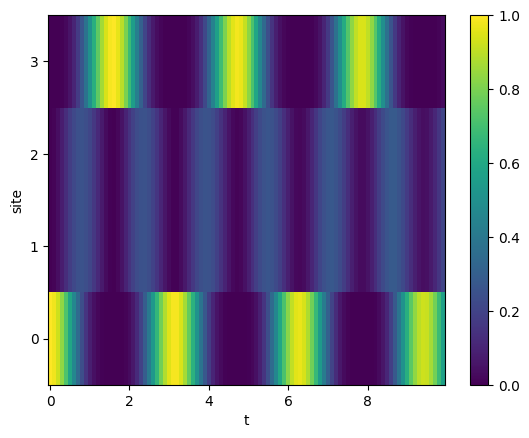

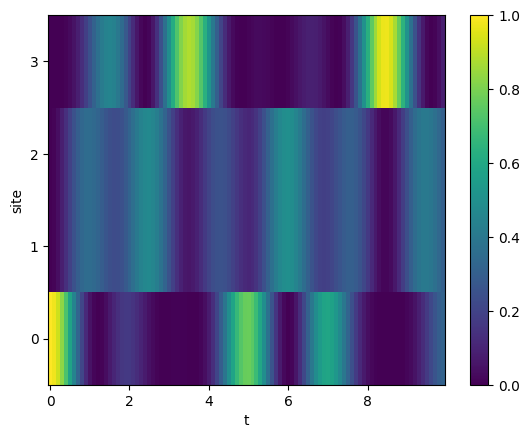

In [52]:
#this for example allows to plot the localization probability in each verteg of the graph
plot_evo_mat_heatmap(gr, start = 0, end = 10, by = .1)

#and see how it changes when we twea the internal phase
gr.rephase( np.pi/2,  UPDATE_EIGEN=True)
plot_evo_mat_heatmap(gr, start = 0, end = 10, by = .1)

<Axes: xlabel='t', ylabel='θ'>

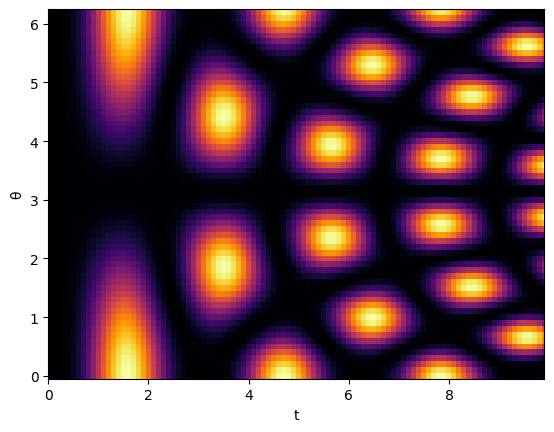

In [51]:
#or the evolution of localization probaiblity on the target site as a funciton of time/phase

plot_evo_vs_phase(gr, start=0, end = 10, by = .1 )

In [53]:
# on top of the simulator methods the package provides some automated way to analyze the transport behaviour
# in particular one is interested in finding:
# - the best transport maxima for a given phase configuration
# - the best out of all the phase configurations

# these definition can vary widely according to the cirteria of choice for the "best event" or "best phase" and furthermore imply a relevant tradeoff between accuracy and lenght of the optimization procedure
# the class TransportParameter allows for the definition of the relevant transport criteria, using ensures a coherent analysis on a single graph or a collection of them.
# all the achiralqw.analyze methods take a TransportParameter instance as "tp

# inside transport parameters one can also define the simulation backend with the variable solver_mode (either "eigen" or "qutip")
# TransportParameters defaluts to EigenSESolver

<Axes: xlabel='t', ylabel='θ'>

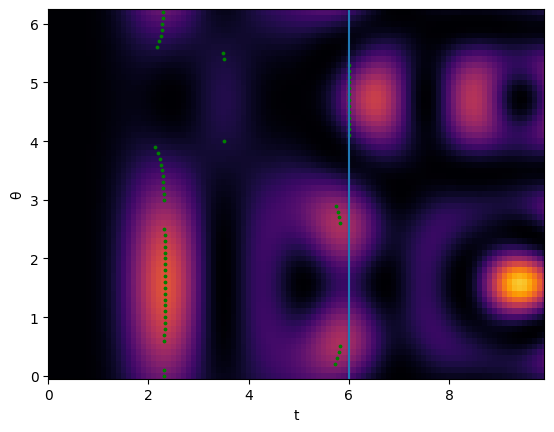

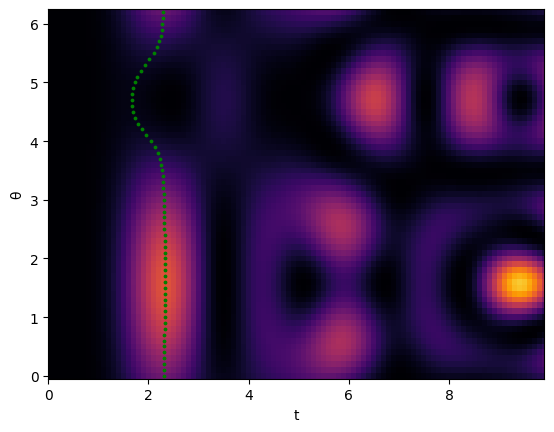

In [65]:
# The variable evt_mode of TransportParameter controls how the best transport event is selected
# Two values are possible:
# "TC" which correspond to brute force maximization on a linearly scaling time window
# "first" which select the first transport


# here below we plot the phase dependent evolution, highlighting the position of the transport maxima found by each method

gr = qwgb.Ring(7)

TCtp = TransportParameters(evt_mode = "TC", TC = 2)
ftp = TransportParameters(evt_mode = "first")

plot_evo_vs_phase(gr, start=0, end = 10, by = .1 , plot_max= True, tp = TCtp)
plot_evo_vs_phase(gr, start=0, end = 10, by = .1 , plot_max= True, tp = ftp)

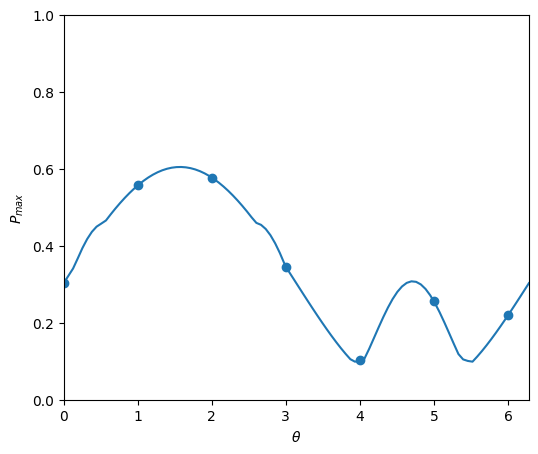

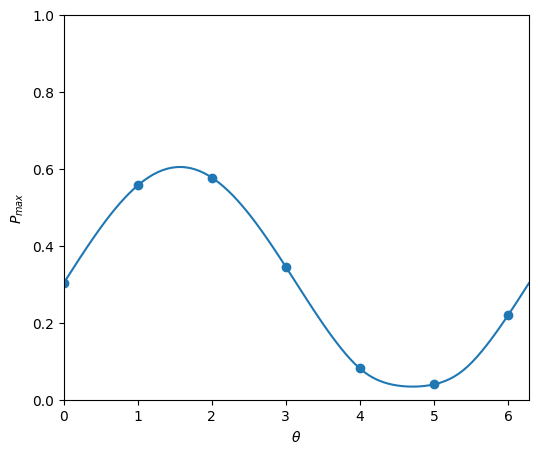

In [78]:
# once a criterion to look for a maximum has been specified one can extract the phase dependend performance of a graph
# that's what the method performance() does
# We can now plot the transport probability as a function of a phase, replicating the results of the plots above

phases = [x for x in range(7)]

tp = TransportParameters(evt_mode = "TC", TC = 2)
perf = [  performance(gr, phi, tp = tp) for phi in phases ]
ax = plot_performance(gr, tp = tp)
ax.scatter(phases, perf)

tp = TransportParameters(evt_mode = "first")
perf = [  performance(gr, phi, tp = tp) for phi in phases ]
ax = plot_performance(gr, tp = tp)
ax.scatter(phases, perf)

<Axes: xlabel='$\\theta_1$', ylabel='$\\theta_2$'>

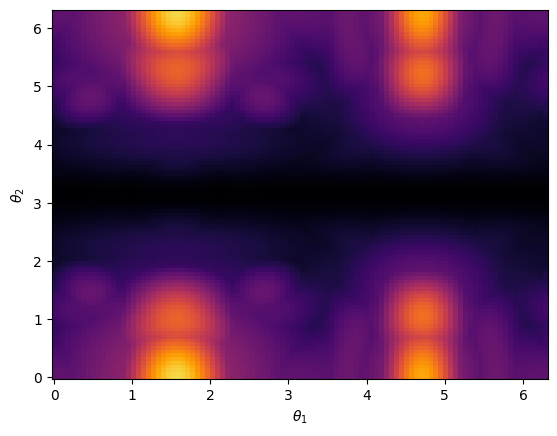

In [81]:
# when two phases are involved we can still visualize what's happening
# (this cell might take a couple of minutes on potato pcs)

gr = qwgb.Ring(7) | qwgb.Ring(8)

tp = TransportParameters(evt_mode = "TC", TC = 3)
plot_performance(gr, tp = tp)

<Axes: xlabel='$\\theta$', ylabel='$P_{max}$'>

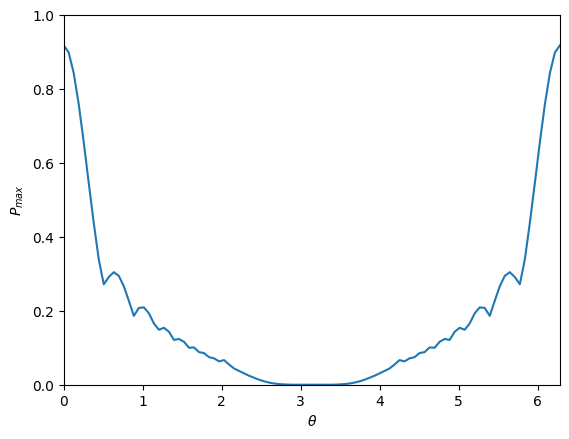

In [88]:
# when the number of phases becomes too big the analysis can be carried on in the equal phases subspace
# plot_performance has an option for that

gr = qwgb.Ring(4).chain(10, HANDLES=True)

tp = TransportParameters(evt_mode = "TC", TC = 3)
plot_performance(gr, tp = tp, mode = "diag")

<Axes: xlabel='$\\theta$', ylabel='$P_{max}$'>

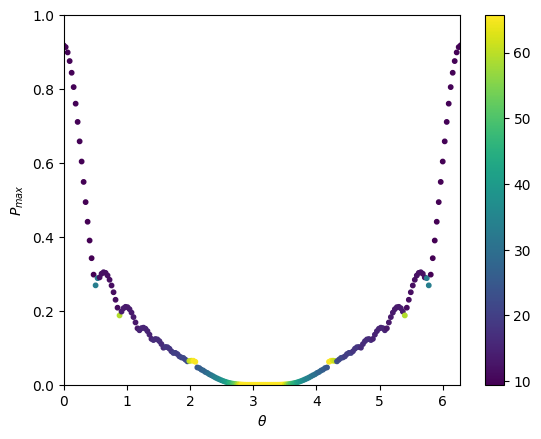

In [90]:
#in these situations we can also add the time of arrival information on top

plot_performance(gr, tp = tp, mode = "time", sample_step=200)

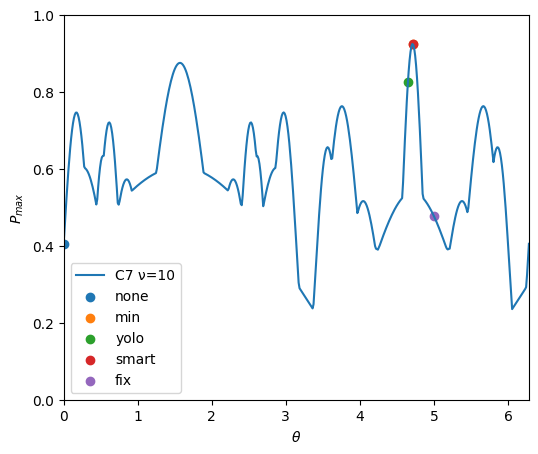

In [103]:
# once we established what a performance is we can ask what's the best performance, that is the best phase configuration
# again one can employ more than one maximization method, which can turn out to be more or less effcient

gr = qwgb.Ring(7)
tp = TransportParameters(evt_mode="TC", TC = 10)

ax = plot_performance(gr, tp=tp, sample_step= 500)

bests = np.empty((5,2))


#perform no optimization whatsoever
tp.opt_mode = "none"
bests[0,0] = optimum_phase(gr, tp = tp)
bests[0,1] = performance(gr, phi_vec = bests[0,0], tp = tp)

#numpy minimize over the performance function
tp.opt_mode = "min"
bests[1,0] = optimum_phase(gr, tp = tp)
bests[1,1] = performance(gr, phi_vec = bests[1,0], tp = tp)

#grid evaluation + find maximum
# yolo can be made less coarse but it will take more time, expecially for graph with mode phases
tp.opt_mode = "yolo"
bests[2,0] = optimum_phase(gr, tp = tp)
bests[2,1] = performance(gr, phi_vec = bests[2,0], tp = tp)

#evaluation on multiples ov pi/2 (very solid for first maxima)
# in this scenario in facts min and smart coincide
tp.opt_mode = "smart"
bests[3,0] = optimum_phase(gr, tp = tp)
bests[3,1] = performance(gr, phi_vec = bests[3,0], tp = tp)

#no optimization with a fixed phase (possibly an efficient reutilization of already known information)
tp.opt_mode = "fix"
tp.fix_phi = "5"
bests[4,0] = optimum_phase(gr, tp = tp)
bests[4,1] = performance(gr, phi_vec = bests[4,0], tp = tp)

for i, mode in enumerate(TransportParameters._opt_modes):
    ax.scatter([bests[i,0]] , [[bests[i,1]]], label = mode)

ax.legend()

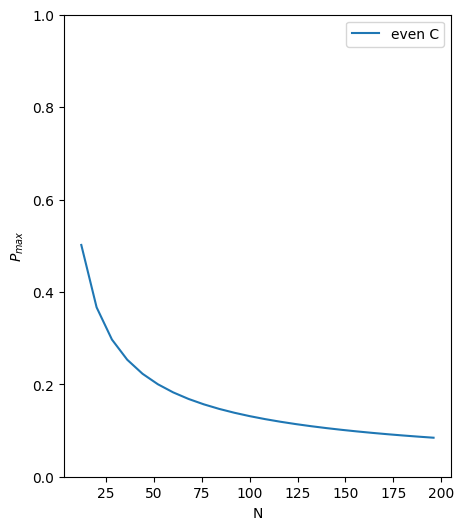

In [108]:
# we can finally define a function that wraps up all these steps and
# given the transport paramters associates univocally a transport probability to a graph

tp = TransportParameters(evt_mode= "first", opt_mode= "smart", solver_mode= "eigen", diag = True)

sizes = [2*x for x in range(6,100,4)]
gr_list = [qwgb.Ring(s) for s in sizes]

perf = [performance_best(gr, tp = tp) for gr in gr_list]

fig, ax = plt.subplots(1,1, figsize = (5,6))
set_progression_plot(ax, x_mode= "size")

ax.plot( sizes, perf, label = "even C")
ax.legend()